# Collecte Data

In [ ]:
import os
import shutil
from google.cloud import storage

# Nom Bucket
bucket_name = 'data-train-mimir'

# Fonction pour nettoyer un répertoire
def clean_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f'Nettoyé le répertoire : {directory}')
    os.makedirs(directory)
    print(f'Créé le répertoire : {directory}')

# Fonction pour télécharger les blobs depuis GCS et préserver la structure des répertoires
def download_blobs(bucket_name, source_blob_folder, destination_folder):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=source_blob_folder)

    for blob in blobs:
        if not blob.name.endswith('/'):
            # Créer le chemin local correspondant au blob
            destination_path = os.path.join(destination_folder, os.path.relpath(blob.name, source_blob_folder))
            os.makedirs(os.path.dirname(destination_path), exist_ok=True)
            blob.download_to_filename(destination_path)
            print(f'Downloaded {blob.name} to {destination_path}')

# Nettoyer les répertoires de train et test
clean_directory('data/train')
clean_directory('data/test')

# Téléchargement des blobs depuis le dossier 'data/train' du bucket GCS vers le dossier local 'data/train'
download_blobs(bucket_name, 'data/train', 'data/train')

# Téléchargement des blobs depuis le dossier 'data/test' du bucket GCS vers le dossier local 'data/test'
download_blobs(bucket_name, 'data/test', 'data/test')


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Downloaded data/train/NonDemented/nonDem1566.jpg to data/train/NonDemented/nonDem1566.jpg
Downloaded data/train/NonDemented/nonDem1567.jpg to data/train/NonDemented/nonDem1567.jpg
Downloaded data/train/NonDemented/nonDem1568.jpg to data/train/NonDemented/nonDem1568.jpg
Downloaded data/train/NonDemented/nonDem1569.jpg to data/train/NonDemented/nonDem1569.jpg
Downloaded data/train/NonDemented/nonDem157.jpg to data/train/NonDemented/nonDem157.jpg
Downloaded data/train/NonDemented/nonDem1570.jpg to data/train/NonDemented/nonDem1570.jpg
Downloaded data/train/NonDemented/nonDem1571.jpg to data/train/NonDemented/nonDem1571.jpg
Downloaded data/train/NonDemented/nonDem1572.jpg to data/train/NonDemented/nonDem1572.jpg
Downloaded data/train/NonDemented/nonDem1573.jpg to data/train/NonDemented/nonDem1573.jpg
Downloaded data/train/NonDemented/nonDem1574.jpg to data/train/NonDemented/nonDem1574.jpg
Downloaded data/train/No

#Importations

In [ ]:
### Manipulation de données
import numpy as np
import pandas as pd
import os
from collections import defaultdict

### Traitement d'images
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

### Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

### Prétraitement et manipulation de données
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

### Modélisation avec Keras et TensorFlow
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import keras.backend as K

# TensorFlow Keras specific
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical

### Utilitaires
from tqdm import tqdm
from google.cloud import storage

# Initialiser le client GCS
client = storage.Client()

def upload_to_gcs(local_file_path, bucket_name, gcs_destination_path):
    """Upload un fichier local vers GCS."""
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(gcs_destination_path)
    blob.upload_from_filename(local_file_path)
    print(f'Uploaded {local_file_path} to {gcs_destination_path} in bucket {bucket_name}')

In [ ]:
# Parcourir les sous-dossiers pour récupérer les chemins d'images et les labels
images = []
labels = []
for subfolder in tqdm(os.listdir('data')):
    subfolder_path = os.path.join('data', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2 = os.path.join(subfolder_path, folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
data = pd.DataFrame({'image': images, 'label': labels})

100%|██████████| 2/2 [00:00<00:00, 175.58it/s]


#Entraînement du modèle global

<ipython-input-4-de05864b8906>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['label'], palette='Set2')


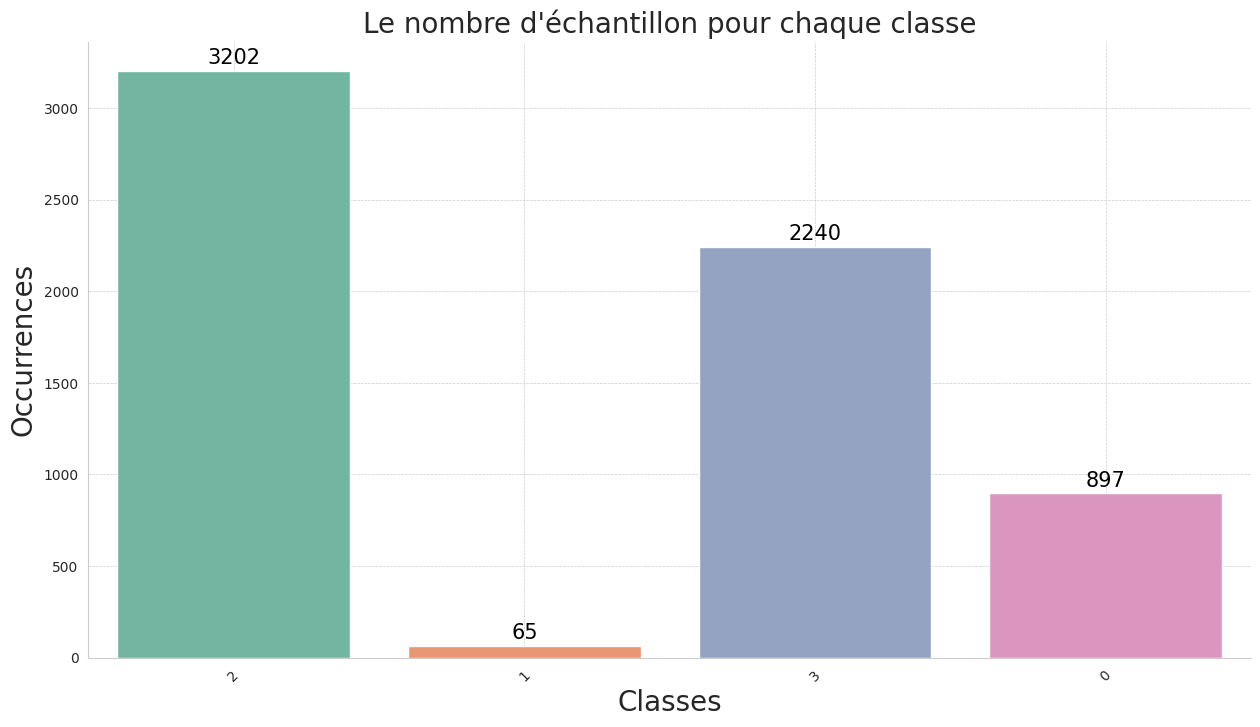

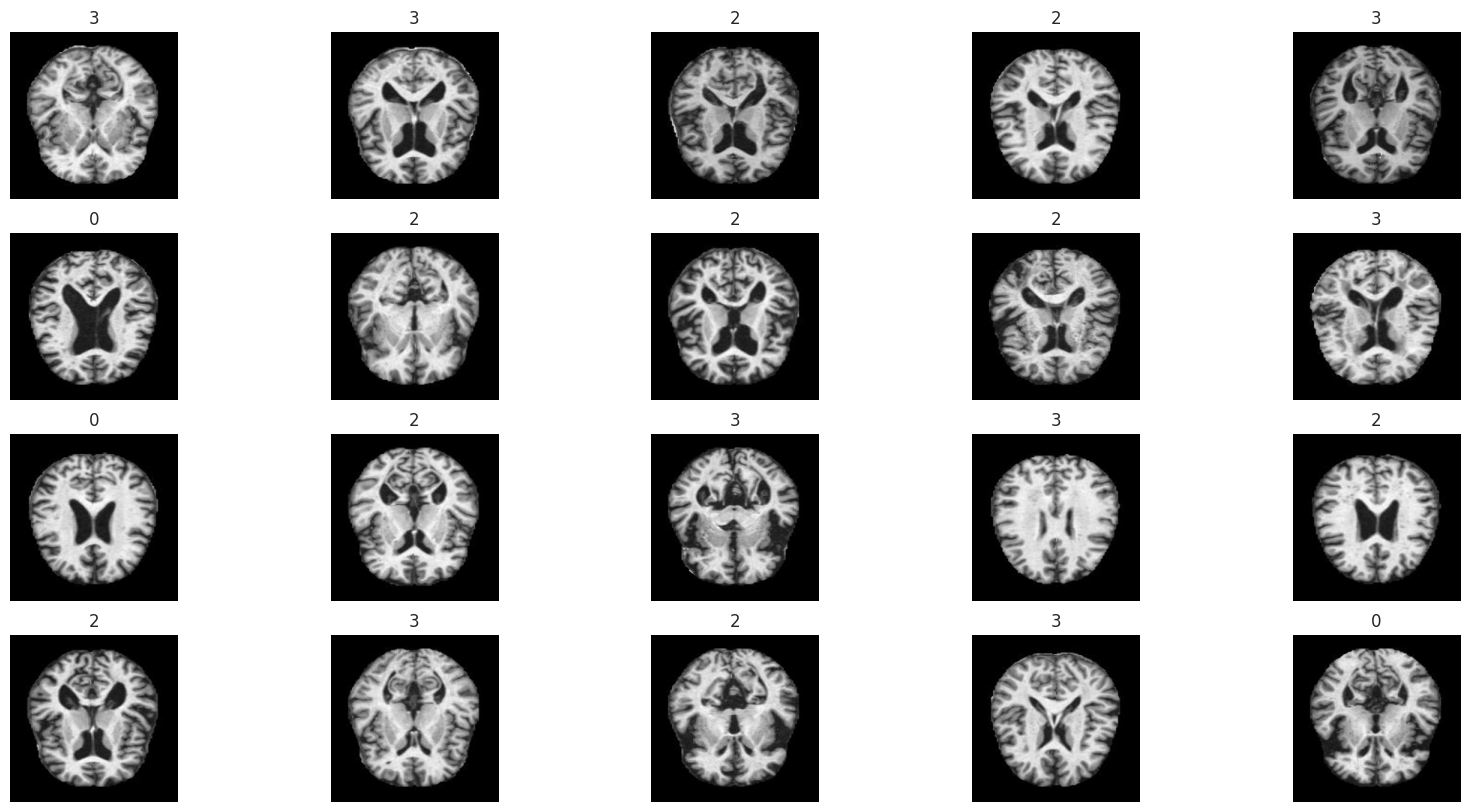

Found 6400 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


(12800, 176, 176, 3) (12800, 4)


<ipython-input-4-de05864b8906>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=labels, palette='Set1')


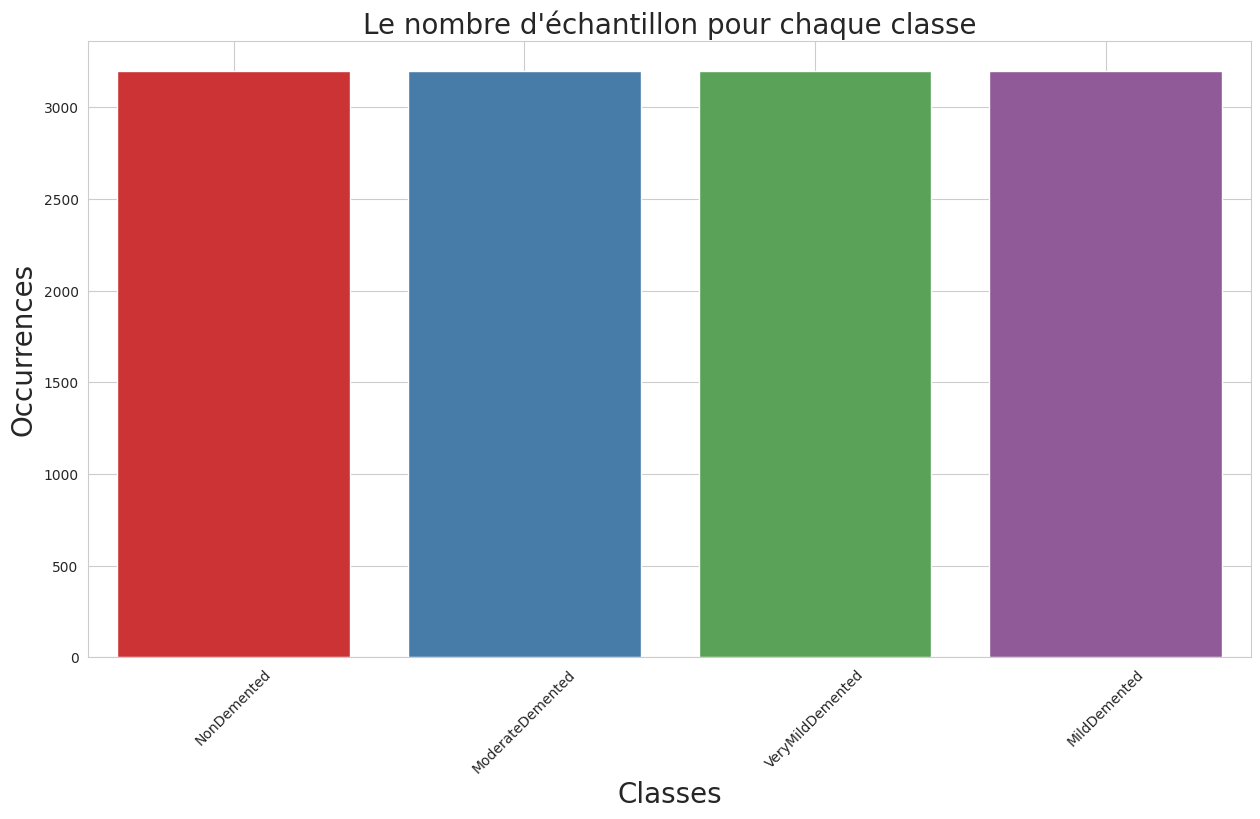

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
94765736/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 6, 6, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 batch_normalization (Batch  (None, 73728)             294912    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                2359

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/280 [==============================] - 59s 193ms/step - loss: 0.7610 - accuracy: 0.6763 - val_loss: 0.6007 - val_accuracy: 0.7797
Epoch 2/100
280/280 [==============================] - 53s 188ms/step - loss: 0.5404 - accuracy: 0.7744 - val_loss: 0.3930 - val_accuracy: 0.8557
Epoch 3/100
280/280 [==============================] - 53s 189ms/step - loss: 0.4658 - accuracy: 0.8133 - val_loss: 0.2994 - val_accuracy: 0.9068
Epoch 4/100
280/280 [==============================] - 53s 188ms/step - loss: 0.4219 - accuracy: 0.8290 - val_loss: 0.2573 - val_accuracy: 0.9099
Epoch 5/100
280/280 [==============================] - 52s 188ms/step - loss: 0.3757 - accuracy: 0.8521 - val_loss: 0.2260 - val_accuracy: 0.9271
Epoch 6/100
280/280 [==============================] - 53s 188ms/step - loss: 0.3458 - accuracy: 0.8628 - val_loss: 0.2072 - val_accuracy: 0.9349
Epoch 7/100
280/280 [==============================] - 53s 188ms/step - loss: 0.3344 - accuracy: 0.8686 - val_loss: 0.1930 - val_accurac

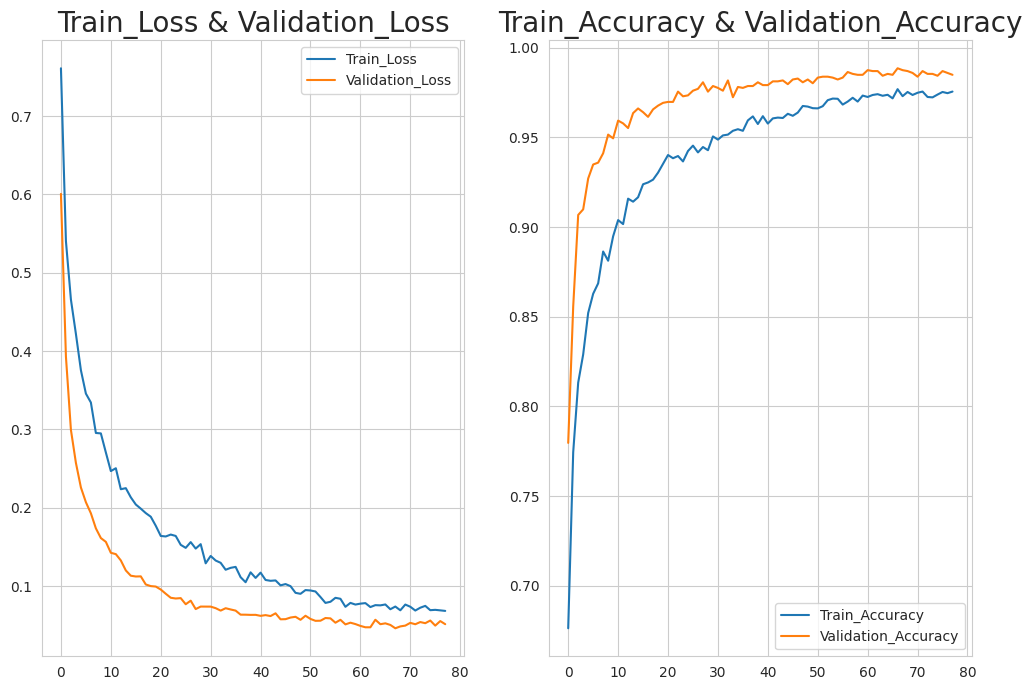

60/60 [==============================] - 10s 154ms/step - loss: 0.0608 - accuracy: 0.9854
Test Loss = 0.06075607240200043
Test Accuracy = 0.9854166507720947
60/60 [==============================] - 10s 156ms/step


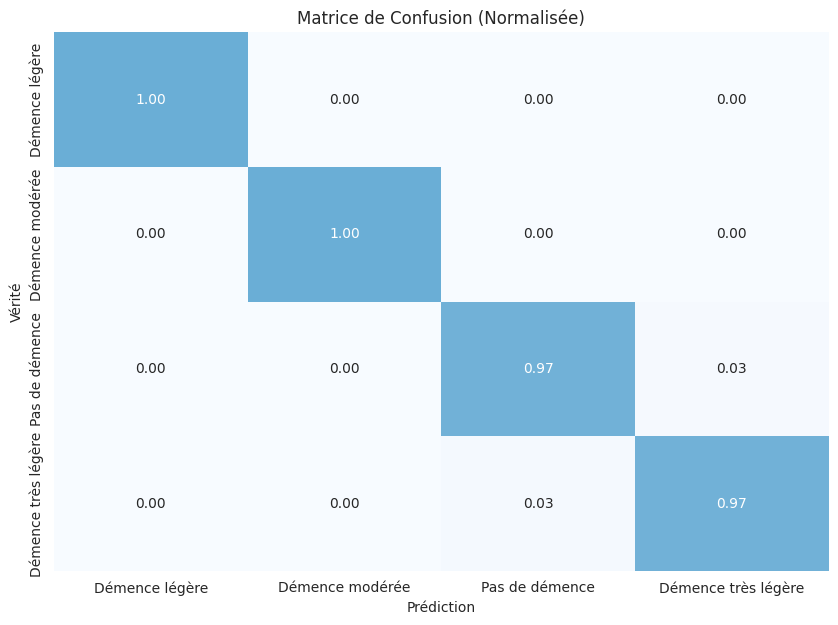

FileNotFoundError: [Errno 2] No such file or directory: 'confusion_matrix_global.png'

In [ ]:
# Encoder les labels
df = data.copy()
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Convertir les labels encodés en chaînes de caractères
df['label'] = df['label'].astype(str)

# Graphique
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=df['label'], palette='Set2')

# Ajouter des étiquettes et un titre
ax.set_xlabel("Classes", fontsize=20)
ax.set_ylabel("Occurrences", fontsize=20)
plt.title('Le nombre d\'échantillon pour chaque classe', fontsize=20)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)

# Ajouter des annotations à chaque barre
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline',
                fontsize=15, color='black', xytext=(0, 5),
                textcoords='offset points')

# Retirer les bordures supérieures et droites
sns.despine()
plt.show()

# Afficher des exemples d'images
plt.figure(figsize=(20, 10))
for n, i in enumerate(np.random.randint(0, len(df), 20)):
    plt.subplot(4, 5, n + 1)
    img = cv2.imread(df.image[i])
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i], fontsize=12)
plt.show()

Size = (176, 176)
work_dr = ImageDataGenerator(rescale=1./255)
train_data_gen = work_dr.flow_from_dataframe(df, x_col='image', y_col='label', target_size=Size, batch_size=6500, shuffle=False)

for i in range(len(train_data_gen)):
    train_data, train_labels = train_data_gen[i]

class_num = np.array(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])

# Rééchantillonner avec SMOTE
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176, 176, 3)
print(train_data.shape, train_labels.shape)

# Mettre à jour les labels après SMOTE
labels = [class_num[i] for i in np.argmax(train_labels, axis=1)]

# Afficher le graphique de comptage des classes rééchantillonnées
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=labels, palette='Set1')
ax.set_xlabel("Classes", fontsize=20)
ax.set_ylabel("Occurrences", fontsize=20)
plt.title('Le nombre d\'échantillon pour chaque classe', fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

X_train, X_test1, y_train, y_test1 = train_test_split(train_data, train_labels, test_size=0.3, random_state=42, shuffle=True, stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42, shuffle=True, stratify=y_test1)
print('X_train shape is ', X_train.shape)
print('X_test shape is ', X_test.shape)
print('y_train shape is ', y_train.shape)
print('y_test shape is ', y_test.shape)


class_num = 4
input_shape = (176, 176, 3)
base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=Input(shape=input_shape))

for layer in base_model.layers:
    layer.trainable = False

# Construire le modèle
model = tf.keras.Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(class_num, activation='softmax'))
model.build((None,) + input_shape)
ResNet = model
ResNet.summary()

# Spécifiez le chemin local et GCS pour le modèle
local_model_path = "models/ResNet50_global.h5"
bucket_name = 'data-train-mimir'

# Configurer les callbacks et compiler le modèle
checkpoint_cb = ModelCheckpoint(local_model_path, save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
ResNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
hist = ResNet.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

# Charger le meilleur modèle sauvegardé
ResNet = load_model(local_model_path)

# Afficher les résultats de l'entraînement
hist_ = pd.DataFrame(hist.history)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(hist_['loss'], label='Train_Loss')
plt.plot(hist_['val_loss'], label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss', fontsize=20)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist_['accuracy'], label='Train_Accuracy')
plt.plot(hist_['val_accuracy'], label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy', fontsize=20)
plt.legend()
plt.show()

score, acc = ResNet.evaluate(X_test, y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

predictions = ResNet.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_test_ = np.argmax(y_test, axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})

CM = confusion_matrix(y_test_, y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(CM_percent, fmt='.2f', center=True, cbar=False, annot=True, cmap='Blues', xticklabels=['Démence légère', 'Démence modérée','Pas de démence','Démence très légère'], yticklabels=['Démence légère', 'Démence modérée','Pas de démence','Démence très légère'])
plt.title('Matrice de Confusion (Normalisée)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.show()

ClassificationReport = classification_report(y_test_, y_pred, target_names=label_encoder.classes_)
print('Classification Report is : ', ClassificationReport)

#Evaluation

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Chemin vers le dossier des nouvelles données de test
test_data_dir = 'data/test'

# Prétraitement des nouvelles données de test
new_test_images = []
new_test_labels = []
image_paths = []

for subfolder in tqdm(os.listdir(test_data_dir)):
    subfolder_path = os.path.join(test_data_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (176, 176))  # Utilisez la même taille que celle utilisée pour l'entraînement
                new_test_images.append(img)
                new_test_labels.append(subfolder)
                image_paths.append(img_path)

# Filtrer les classes nécessaires pour les données de test
filtered_test_data = [(img, label, path) for img, label, path in zip(new_test_images, new_test_labels, image_paths) if label in ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']]
if not filtered_test_data:
    print("Erreur : aucune image de test trouvée pour les classes spécifiées.")
else:
    new_test_images, new_test_labels, image_paths = zip(*filtered_test_data)

    new_test_images = np.array(new_test_images)
    new_test_labels = np.array(new_test_labels)

    # Normalisation des images de test
    new_test_images = new_test_images / 255.0

    # Encodage des étiquettes
    new_test_labels_encoded = label_encoder.transform(new_test_labels)

    # Conversion des étiquettes en one-hot encoding pour 4 classes
    new_test_labels_one_hot = to_categorical(new_test_labels_encoded, num_classes=4)

    # Évaluation du modèle sur les nouvelles données de test
    score, acc = ResNet.evaluate(new_test_images, new_test_labels_one_hot)
    print(f'Accuracy on new test data: {acc}')
    print(f'Loss on new test data: {score}')

    # Prédictions sur les nouvelles données de test
    predictions = ResNet.predict(new_test_images)
    y_pred = np.argmax(predictions, axis=1)

    # Rapport de classification pour 4 classes
    report = classification_report(new_test_labels_encoded, y_pred, target_names=label_encoder.classes_)
    print(report)

    plt.figure(figsize=(12, 8))
    for i in range(10):  # Affichez les 10 premières images de test et leurs prédictions
        plt.subplot(2, 5, i + 1)
        plt.imshow(new_test_images[i])
        plt.title(f'Pred: {label_encoder.inverse_transform([y_pred[i]])[0]}\nTrue: {new_test_labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    CM = confusion_matrix(new_test_labels_encoded, y_pred)
    CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(CM_percent, fmt='.2f', center=True, cbar=False, annot=True, cmap='Blues', xticklabels=['Démence légère', 'Démence modérée','Pas de démence','Démence très légère'], yticklabels=['Démence légère', 'Démence modérée','Pas de démence','Démence très légère'])
    plt.title('Matrice de Confusion (Normalisée)')
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité')
    plt.savefig('confusion_matrix_global.png')  # Enregistrement sous forme d'image PNG
    plt.show()


# Upload des modèles

In [ ]:
from google.cloud import storage

# Fonction pour télécharger un fichier local vers GCS
def upload_to_gcs(local_file_path, bucket_name, gcs_destination_path):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(gcs_destination_path)
    blob.upload_from_filename(local_file_path)
    print(f'Uploaded {local_file_path} to {gcs_destination_path} in bucket {bucket_name}')

# Modèles
bucket_name = 'data-train-mimir'
model_path  = "models/ResNet50_global.h5"

# Téléchargez les modèles enregistrés localement vers GCS
upload_to_gcs(model_path, bucket_name, model_path)


# Nettoyage avant fin du job

In [ ]:
# Nettoyer les répertoires de train et test
clean_directory('data/train')
clean_directory('data/test')